# IMPORTING PACKAGES

In [34]:
#pip install umap-learn
import csv
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import umap
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist
%matplotlib inline

# READING DATA AND CHECKING FOR NaN

In [35]:
train = pd.read_csv('HW4_imagedata.txt', header=None, dtype=int)
if train.isna().values.any():
    print("DataFrame contains NaN values")
else:
    print("DataFrame does not contain NaN values")
train.head(5)

DataFrame does not contain NaN values


,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# CHECKING FOR BEST NUMBER OF DIMENSIONS USING PCA

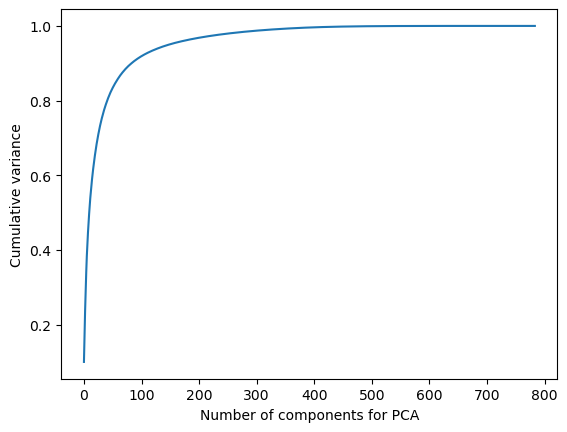

In [70]:
pca = PCA().fit(train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components for PCA')
plt.ylabel('Cumulative variance')
plt.show()

# DIMENSIONALITY REDUCTION USING PCA

In [29]:
pca = PCA(n_components=100)
pca.fit(train)
principal_components = pca.transform(train)
column_names = ["PC" + str(i) for i in range(1, 101)]
train_pca = pd.DataFrame(data = principal_components, columns = column_names)

# CHECKING FOR BEST NUMBER OF DIMENSIONS USING SVD

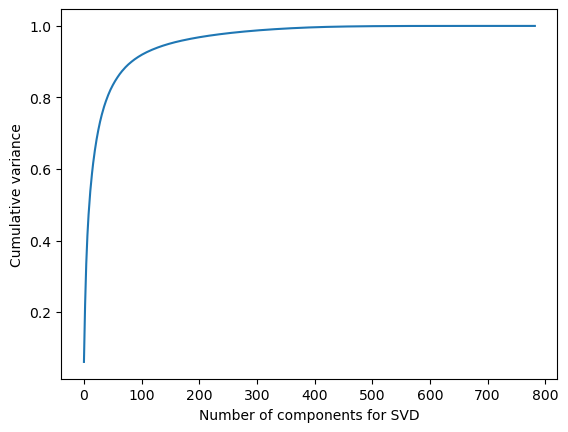

In [44]:
svd = TruncatedSVD(n_components=train.shape[1]-1)
train_reduced = svd.fit_transform(train)
variance_ratio = svd.explained_variance_ratio_
plt.plot(np.cumsum(variance_ratio))
plt.xlabel('Number of components for SVD')
plt.ylabel('Cumulative variance')
plt.show()

# DIMENSIONALITY REDUCTION USING SVD

In [36]:
svd = TruncatedSVD(n_components=100)
train_svd = svd.fit_transform(train)

# DIMENSIONALITY REDUCTION USING UMAP

In [37]:
umap_model = umap.UMAP(n_components=2)
train_umap = umap_model.fit_transform(train_svd)
print(train_umap)

[[ 2.5422535  5.509562 ]
 [13.303318   5.0514064]
 [-2.8547645  5.280907 ]
 ...
 [-1.6507052  4.683269 ]
 [-0.7306829  3.16655  ]
 [ 4.625076   5.3089676]]


# SCALING OF DATA

In [38]:
scaler = StandardScaler()
X = scaler.fit_transform(train_umap)
array = np.array(X)
# convert the array to an array of vectors
vectors = np.apply_along_axis(lambda x: np.array(x), axis=1, arr=array)
print(vectors)

[[-0.02888176  0.26808375]
 [ 2.0148246   0.11739954]
 [-1.0538658   0.19288075]
 ...
 [-0.82519484 -0.00367828]
 [-0.6504672  -0.5025166 ]
 [ 0.36668107  0.20210963]]


# DIMENSTIONALITY REDUCTION USING t-SNE

In [24]:
#scaler = StandardScaler()
#scaler = RobustScaler()
scaler = MaxAbsScaler()
X = scaler.fit_transform(train)

tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000)
X_tsne = tsne.fit_transform(X)
array = np.array(X_tsne)
# convert the array to an array of vectors
vectors = np.apply_along_axis(lambda x: np.array(x), axis=1, arr=array)
print(vectors)

[[-13.118776   -4.3383393]
 [ 73.678665   27.586506 ]
 [-39.979805  -27.501177 ]
 ...
 [-53.587166  -19.183908 ]
 [-24.293127  -27.045412 ]
 [ 12.827836   18.516462 ]]


# K-MEANS IMPLEMENTATION

In [43]:
class Kmeans:

    def __init__(self, K_value=3, iterations=300, distance_measure='euclidean'):
        self.K_value = K_value
        self.iterations = iterations
        self.distance_measure = distance_measure
        self.clusters = []
        for i in range(self.K_value):
            self.clusters.append([])
        self.centroids = []

    def form_clusters(self, centroids):
        distances = cdist(self.X, centroids, self.distance_measure)
        cluster_indices = np.argmin(distances, axis=1)
        clusters = [[] for _ in range(self.K_value)]
        for i, idx in enumerate(cluster_indices):
            clusters[idx].append(i)
        return clusters

    def calculate_centroids(self, clusters):
        centroids = np.zeros((self.K_value, self.n_features))
        for cluster in range(self.K_value):
            cluster_mean = np.mean(self.X[clusters[cluster]], axis=0)
            centroids[cluster] = cluster_mean
        return centroids

    def convergence(self, centroids_old, centroids):
        distance_measure = cdist(centroids_old, centroids, self.distance_measure).flatten()
        return sum(distance_measure) == 0

    def centroid_initialization(self, X):
        self.n_samples, self.n_features = X.shape
        # select first centroid randomly
        first_centroid_index = np.random.choice(self.n_samples)
        self.centroids.append(X[first_centroid_index])
        for k in range(1, self.K_value):
            distances = cdist(X, self.centroids, self.distance_measure)
            min_distances = np.min(distances, axis=1)
            probability_distribution = min_distances / np.sum(min_distances)
            new_centroid_index = np.random.choice(self.n_samples, p=probability_distribution)
            self.centroids.append(X[new_centroid_index])

    def predict(self, X):
        self.X = X
        self.centroid_initialization(X)
        for iteration in range(self.iterations):
            # update clusters
            self.clusters = self.form_clusters(self.centroids)
            centroids_old = self.centroids
            self.centroids = self.calculate_centroids(self.clusters)
            # check for convergence
            if self.convergence(centroids_old, self.centroids):
                #print("Convergence reached after {} iterations".format(iteration))
                break
        # cluster labels
        cluster_labels = np.empty(self.n_samples)
        for cluster_index in range(len(self.clusters)):
            for sample_index in self.clusters[cluster_index]:
                cluster_labels[sample_index] = cluster_index
        self.cluster_labels = cluster_labels
        # Calculate sum of squared error
        self.sse = self.calculate_sse(X)
        return self.cluster_labels

    def calculate_sse(self, X):
        sse = 0
        for cluster_index in range(len(self.clusters)):
            centroid = self.centroids[cluster_index]
            cluster_samples = X[self.clusters[cluster_index]]
            centroid_distances = cdist(cluster_samples, [centroid], self.distance_measure)
            sse += np.sum(centroid_distances ** 2)
        return sse

# MODEL FITTING WITH 10 CLUSTERS

In [44]:
model = Kmeans(K_value=10, iterations = 300, distance_measure='euclidean')
predictions = model.predict(vectors)
predictions = predictions.astype(int)
print(predictions)
predictions_final=[]

for i in predictions:
    j = i+1
    predictions_final.append(j)

print(model.sse)
print(predictions_final)
print(len(predictions_final))
result_df = pd.DataFrame(predictions_final)
print(result_df.value_counts())
#result_df.to_csv('image_kmeansplus10_euc_absscale_tsne_300_nosklearn.txt', sep=' ', header=False, index=False)
#result_df.to_csv('image_kmeansplus10_cosine_comp90_cd_noscale_svd_300_nosklearn.txt', sep=' ', header=False, index=False)

[0 3 8 ... 8 8 0]
859.0896444392571


# PLOT FOR NUMBER OF CLUSTERS VS SUM OF SQUARED ERROR

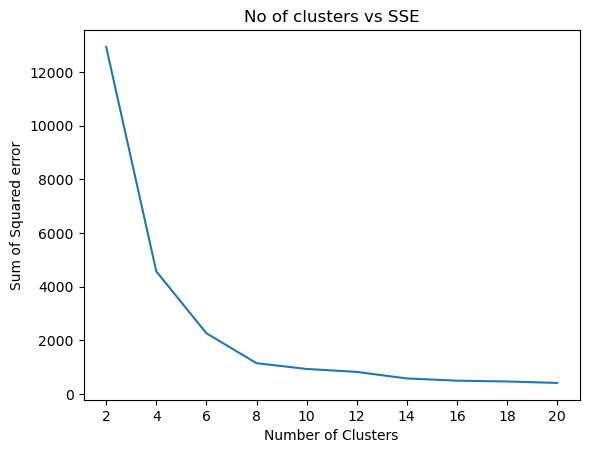

In [45]:
cluster_range = [2,4,6,8,10,12,14,16,18,20]
sse= []
for cluster in cluster_range:
    km = Kmeans(K_value=cluster, iterations=300, distance_measure='euclidean')
    km.predict(vectors)
    error = km.sse
    sse.append(error)

fig, ax = plt.subplots()
ax.plot(cluster_range, sse)

ax.set_xticks(cluster_range)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Sum of Squared error')
ax.set_title('No of clusters vs SSE')
plt.show()

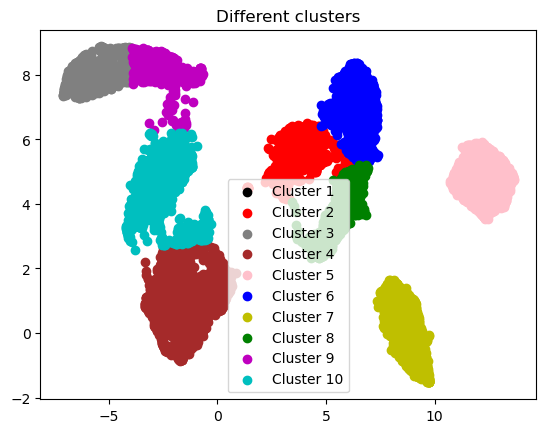

In [46]:
import matplotlib.pyplot as plt

colors = ['black', 'r', 'gray', 'brown', 'pink', 'b', 'y', 'g', 'm', 'c']
labels1 = np.array(predictions_final)
for i in range(len(set(predictions_final))):
    plt.scatter(train_umap[labels1 == i, 0], train_umap[labels1 == i, 1], color=colors[i % len(colors)], label=f'Cluster {i+1}')

plt.title('Different clusters')
plt.legend()
plt.show()